In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# import pyflux as pf
import tensorflow as tf
import os

matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

In [3]:
total =  pd.read_csv('avg_price.txt',encoding='gbk')
samp = total[total['AREA'] == u'朝阳'].groupby(['DATA_DATE_RM']).mean().reset_index()

samp.head()

C:\Users\laiwei\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DATA_DATE_RM,Unnamed: 0,AVG_PRICE,DATA_DATE_Y,DATA_DATE_M
0,-1.0,10727.875000,7885.000000,2003.0,11.125
1,0.0,13109.314050,6948.864407,2003.0,12.000
2,1.0,17110.375000,7003.870968,2004.0,1.000
3,2.0,22821.100000,6019.555556,2004.0,2.100
4,3.0,17362.066667,7576.533333,2004.0,3.000


[[  7885.        ]
 [  6948.86425781]
 [  7003.87109375]
 [  6019.55566406]
 [  7576.53320312]
 [  8737.05859375]
 [  6283.75      ]
 [  8150.        ]
 [  7895.85302734]
 [  8073.95166016]
 [  8567.16699219]
 [  7549.94580078]
 [  8267.37988281]
 [  7250.56542969]
 [  8421.05566406]
 [  8024.09082031]
 [  7221.71435547]
 [  8508.20019531]
 [  8382.12792969]
 [  9781.15429688]
 [  9399.69726562]
 [  9867.02734375]
 [  8199.03027344]
 [  9573.68457031]
 [  9426.22851562]
 [  9771.78417969]
 [ 10034.43457031]
 [  9444.35253906]
 [  8901.52148438]
 [  8778.45703125]
 [  9254.81445312]
 [  9877.84277344]
 [ 11752.68261719]
 [ 10687.48730469]
 [ 11031.95605469]
 [ 11780.29589844]
 [ 12071.5       ]
 [ 11490.90917969]
 [ 13629.33300781]
 [ 12434.90039062]
 [ 12318.18164062]
 [ 14083.87109375]
 [ 12732.8125    ]
 [ 14040.51269531]
 [ 14097.14257812]
 [ 15720.        ]
 [ 17368.76171875]
 [ 18551.96679688]
 [ 21006.66601562]
 [ 21925.        ]
 [ 19852.94140625]
 [ 21092.85742188]
 [ 19847.619

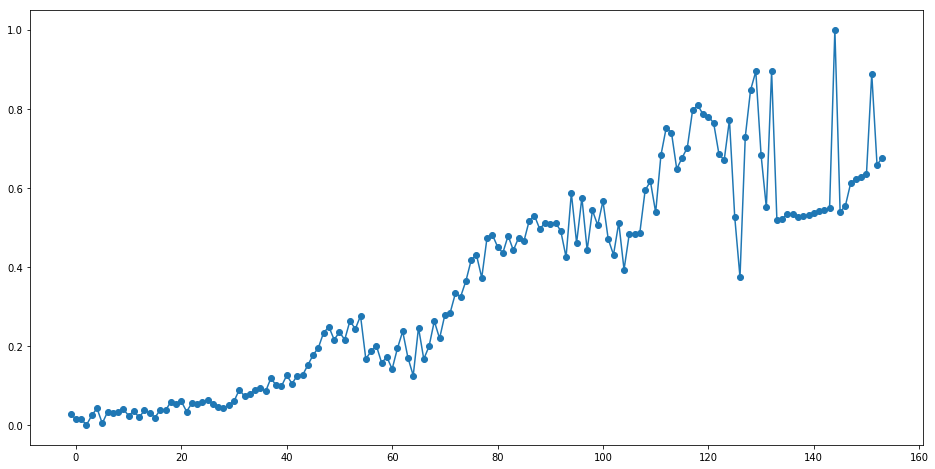

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

length = samp.shape[0]
index = samp.DATA_DATE_RM.values
samples = samp['AVG_PRICE'].astype(np.float32).values.reshape(length,1)
print(samples)
min_max_scaler = preprocessing.MinMaxScaler()
samples = min_max_scaler.fit_transform(samples)
plt.plot(index,samples.reshape(length,1),'-o')
plt.show()

<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png">
LSTM
$$hf_{t}=\sigma(W_{f}[h_{t-1},x_{t}] + b_{f})$$

$$hi_{t}=\sigma(W_{i}[h_{t-1},x_{t}] + b_{i})$$

$$ho_{t}=\sigma(W_{o}[h_{t-1},x_{t}] + b_{o})$$

$$hc_{t}=\tanh(W_{c}[h_{t-1},x_{t}] + b_{c})$$

$$c_{t}=hf_{t}\times c_{t-1} + hi_{t}\times hc_{t}$$

$$h_{t}=ho_{t}\times \tanh (c_{t})$$

In [17]:
H = 256 # Number of LSTM layer's neurons
D = 1 # Number of input dimension == number of items in vocabulary
Z = H + D # Because we will concatenate LSTM state with the input
time_step = 30 #Number of time_step to backprop
num_epochs = 10000
learning_rate = 0.001

tf.reset_default_graph()

Wf = tf.Variable(np.random.randn(Z, H) / np.sqrt(Z / 2.),dtype=tf.float32,name='Wf')
Wi = tf.Variable(np.random.randn(Z, H) / np.sqrt(Z / 2.),dtype=tf.float32,name='Wi')
Wc = tf.Variable(np.random.randn(Z, H) / np.sqrt(Z / 2.),dtype=tf.float32,name='Wc')
Wo = tf.Variable(np.random.randn(Z, H) / np.sqrt(Z / 2.),dtype=tf.float32,name='Wo')
Wy = tf.Variable(np.random.randn(H, D) / np.sqrt(D / 2.),dtype=tf.float32,name='Wy')

bf = tf.Variable(np.zeros((1,H)),dtype=tf.float32,name='bf')
bi = tf.Variable(np.zeros((1,H)),dtype=tf.float32,name='bi')
bc = tf.Variable(np.zeros((1,H)),dtype=tf.float32,name='bc')
bo = tf.Variable(np.zeros((1,H)),dtype=tf.float32,name='bo')
by = tf.Variable(np.zeros((1,D)),dtype=tf.float32,name='by')


#init h value
init_h = tf.placeholder(tf.float32, [1,H],name='init_h')
init_c = tf.placeholder(tf.float32, [1,H],name='init_c')
X_placeholder = tf.placeholder(tf.float32,[1,time_step],name='X_placeholder')
Y_placeholder = tf.placeholder(tf.float32,[1,time_step],name='Y_placeholder')
labels_series = tf.unstack(Y_placeholder, axis=1)

In [18]:
current_h = init_h
current_c = init_c
Y_predict_series = []
# lstm forword
for i in range(time_step):
    #1*D matrix
    current_input = X_placeholder[:,i:i + D]
    # mix input and hidden units; 1*Z matrix
    input_and_h_concatenated = tf.concat([current_input,current_h],1) # 1*Z matrinx
    hf = tf.sigmoid(tf.matmul(input_and_h_concatenated,Wf) + bf) # 1*H matrix
    hi = tf.sigmoid(tf.matmul(input_and_h_concatenated,Wi) + bi) # 1*H matrix
    ho = tf.sigmoid(tf.matmul(input_and_h_concatenated,Wo) + bo) # 1*H matrix
    hc = tf.tanh(tf.matmul(input_and_h_concatenated,Wc) + bc) #1*H matrix
    
    #set current state
    current_c = hf * current_c + hi * hc 
    current_h = ho * tf.tanh(current_c) #1*H matrix
    Y_predict = tf.sigmoid(tf.matmul(current_h,Wy) + by)
    # store Y prediction in memery
    Y_predict_series.append(Y_predict)
    

In [19]:
#calculate loss
losses = [tf.squared_difference(output,Y) for output,Y in zip(Y_predict_series,labels_series)]
total_loss = tf.reduce_mean(losses)
tf.summary.scalar("loss", total_loss)
train_step = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(total_loss)

In [20]:
def make_hparam_string(learning_rate, HiddenUnits):
    return "lr_%.0E_%d" % (learning_rate, HiddenUnits)


In [ ]:
# training model
LOGDIR = 'tensorboardlog/'
with tf.Session() as sess:

    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()

    hparam = make_hparam_string(learning_rate,H)
    summ = tf.summary.merge_all()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    #filewriter is how we write the summary protocol buffers to disk
    writer = tf.summary.FileWriter(LOGDIR + hparam)
    writer.add_graph(sess.graph)

    #to show the loss decrease
    loss_list = []

    # orginal 155 points,discard first 4 element, make it 151 points to predict
    x = samples[4:].reshape(1,151)
#     for i in range(x.shape[1]):
#         x[0,i] = (x[0,i]/x[0,0])-1
#     print(x)
    for epoch_idx in range(num_epochs):
        #initialize an empty hidden state
        _current_c = np.zeros((1, H))
        _current_h = np.zeros((1, H))
        y_predict_list = []
    #         print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(x.shape[1] // time_step):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * time_step
            end_idx = start_idx + time_step 
            x_data = x[:,start_idx : end_idx]
            y_data = x[:,start_idx + D:end_idx + D]

            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_c, _current_h, _Y_predict_series,s = sess.run(
                [total_loss, train_step, current_c,current_h, Y_predict_series,summ],
                feed_dict={
                    X_placeholder:x_data,
                    Y_placeholder:y_data,
                    init_h:_current_h,
                    init_c:_current_c
                })

            loss_list.append(_total_loss)
            y_predict_list.append(_Y_predict_series)

        if epoch_idx%5==0:
            writer.add_summary(s, epoch_idx)
        if epoch_idx%100 == 0:
            print("Step",epoch_idx, "Loss", _total_loss)
            #save checkpoints
            saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), i)
plt.plot(loss_list)
plt.show()

Step 0 Loss 0.0516625
Step 100 Loss 0.0240019
Step 200 Loss 0.0256553
Step 300 Loss 0.0259963
Step 400 Loss 0.0259307
Step 500 Loss 0.0257612
Step 600 Loss 0.0255736
Step 700 Loss 0.0253915
Step 800 Loss 0.0252204
Step 900 Loss 0.0250607
Step 1000 Loss 0.0249112
Step 1100 Loss 0.0247707
Step 1200 Loss 0.024638
Step 1300 Loss 0.024512
Step 1400 Loss 0.024392
Step 1500 Loss 0.0242772
Step 1600 Loss 0.0241671
Step 1700 Loss 0.0240613
Step 1800 Loss 0.0239594
Step 1900 Loss 0.0238611
Step 2000 Loss 0.0237662
Step 2100 Loss 0.0236745
Step 2200 Loss 0.0235859
Step 2300 Loss 0.0235003
Step 2400 Loss 0.0234176
Step 2500 Loss 0.0233377
Step 2600 Loss 0.0232607
Step 2700 Loss 0.0231865
Step 2800 Loss 0.0231152
Step 2900 Loss 0.0230467
Step 3000 Loss 0.0229812
Step 3100 Loss 0.0229186
Step 3200 Loss 0.022859
Step 3300 Loss 0.0228024
Step 3400 Loss 0.0227488
Step 3500 Loss 0.0226984
Step 3600 Loss 0.022651
Step 3700 Loss 0.0226068
Step 3800 Loss 0.0225657
Step 3900 Loss 0.0225277
Step 4000 Loss 0.

In [22]:
y_output = []
np.dstack(y_predict_list[0])[0][0]
for series in y_predict_list:
    y_output = np.concatenate([y_output,np.dstack(series)[0][0]])
y_output.shape

(150,)

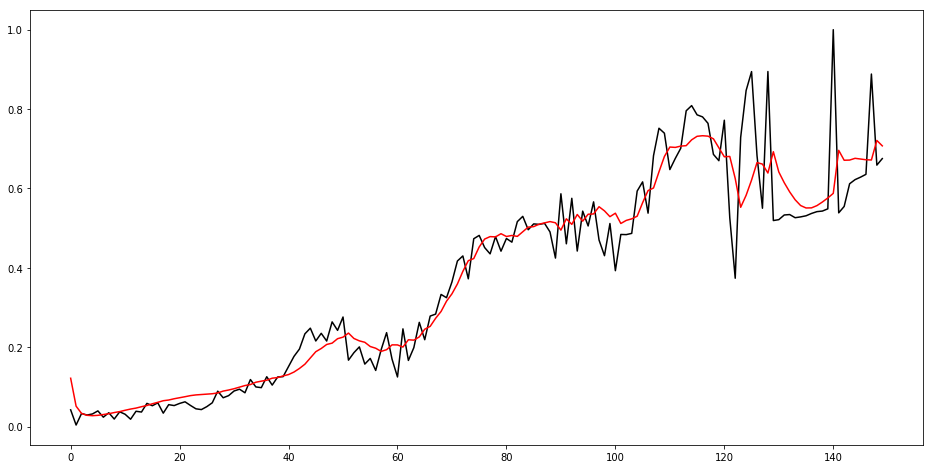

In [23]:
plt.plot(x[0,1:],'black')
plt.plot(y_output,'red')
plt.show()

In [16]:
y_output.shape

(150,)